# Land Cover Pixel Drill

This pixel drill notebook enables you to investigate how the land cover in one precise spot in Australia has changed over the course of 32 years of satelite data being collected.

this notbook runs though the following steps
1) define requiered fuctions
2) load data for selected area
3) plot area, select location for historical analysis
4) plot pixel drill


In [1]:
%matplotlib widget

import datacube
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xarray as xr

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb
from matplotlib import colors as mcolours
from IPython.display import Image
from dea_tools.plotting import xr_animation, rgb
import matplotlib.patheffects as PathEffects
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MaxNLocator
from dea_tools.plotting import display_map
import datacube

In [2]:
#define custom fuctions

def rescale_level3(data):
    """rescale distribution of level three classes to be 0-6 for neat plotting
    Input : xarray DataSet or DataArray
    """
    scale_and_lables = {0:0, 111: 1, 112:2, 124:3, 215:4, 216:5, 220:6}

    for key, value in scale_and_lables.items():
                        data = data.where(data!= key, value)
    return(data)

def click_for_coords(event):
    """
    Define behavior widget to enable extraction of x,y values for point manually selected with mouse click
    For use with Matplotlib Imshow.
    then x and y are not the latitude/logitude value of the pixle but the possition of the pixel in the x and y axies of DataArray.
    this is what you need to latter conduct pixel drill.
    returns:
    ix, iy = x and y position of selected pixel 
    """
    global ix, iy
    ix, iy = event.xdata, event.ydata
    global coords
    coords.append((ix, iy))

    fig.canvas.mpl_disconnect(cid)
    return

def create_colour_map(colours):
    """create colour map and normalisation for plotting Land Cover layers"""
    colour_arr = []
    cblabels = []
    for key, value in colours.items():
        colour_arr.append(np.array(value[:-2])/255)
        cblabels.append(value[-1])

    cmap = mcolours.ListedColormap(colour_arr)
    bounds = list(colours)
    bounds.append(255)
    norm = mcolours.BoundaryNorm(np.array(bounds) - 0.1, cmap.N)
    return cmap, norm

In [3]:
#define level three colourcheme

LEVEL3_COLOUR_SCHEME = { 0   : (255, 255, 255, 255, "No Data"),
                         111 : (172, 188, 45, 255, "Cultivated Terrestrial Vegetation"),
                         112 : (14, 121, 18, 255, "Natural Terrestrial Vegetation"),
                         124 : (30, 191, 121, 255, "Natural Aquatic Vegetation"),
                         215 : (218, 92, 105, 255, "Artificial Surface"),
                         216 : (243, 171, 105, 255, "Natural Bare Surface"),
                         220 : (77, 159, 220, 255, "Water")}

In [4]:
dc = datacube.Datacube()

In [5]:
# Set up a region to load data

#lake George
# point_x, point_y = (-35.1064, 149.4248)

# #canberra
point_x, point_y = (-35.1855, 149.1173)


lat = (point_x-0.05, point_x+0.05)
lon = (point_y-0.05, point_y+0.05)

#display area on map
display_map(x=lon, y=lat)


In [6]:
query = {
    'y': lat,
    'x': lon,
    'time': ('1988', '2020'),
}

# Load DEA Land Cover data from the datacube
all_data = dc.load(product='ga_ls_landcover_class_cyear_2',
#              crs = "EPSG:3577",
             output_crs='EPSG:3577',
              measurements=['level3'],
             resolution=(-25, 25),
             **query)

In [7]:
#select level 3
level3 = all_data.level3


In [8]:
#create colour scheme
layer_cmap, layer_norm = create_colour_map(LEVEL3_COLOUR_SCHEME)

## Plot area of interest and select location for analysis

This plot has a interactive fuction enabled which allows users to select a specific point to analyse in greater detail further down the notebook. To use this feature select a poin on the plot you wish to interrogate by clicking on it with your mouse. Then run the next code cell bellow. The point you selected will then be highlighted on this plot with a red dot.

The Most recent year has been set as default to visualise in this step

##### trouble shooting:
You can move the dot by clocking on a new location and then re-running the next code cell again, unless you have since completed the notebook and generated the graph at the end, in which case you need to re-run this code first to re-generate this plot before selecting a new point.

If you click multible times on the plot before running the next pice of code only the most recent location will be used

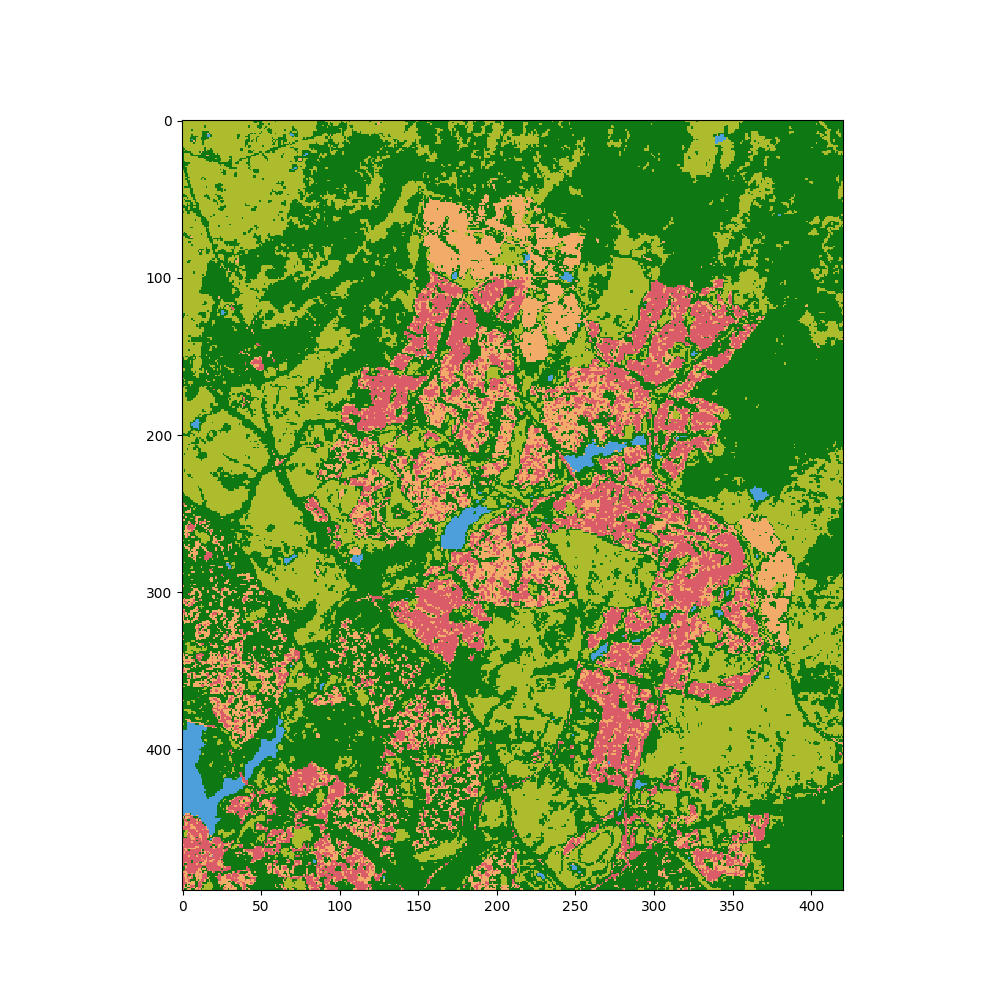

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
# ax = level3[25].plot(cmap=layer_cmap, norm=layer_norm, add_colorbar=True)
ax = plt.imshow(level3[-1], cmap=layer_cmap, norm=layer_norm, interpolation="nearest")
cid = fig.canvas.mpl_connect('button_press_event', click_for_coords)

plt.show()

In [11]:
#RUN THIS CELL TO ENTER/UPDATE Selected point
plt.clf()
ax = plt.imshow(level3[-1], cmap=layer_cmap, norm=layer_norm, interpolation="nearest")
plt.scatter(x =ix, y=iy, c='r', s = 80)


### Conduct pixel drill

In [12]:
#find nearest whole number value for v,y
xcoord = int(ix)
ycoord = int(iy)

#conduct pixel drill on loaded dataset
pixel_timeseries= level3.isel(x=xcoord, y=ycoord,)

#rescale the range of Level 3 classes for beautiful plotting
new_data = rescale_level3(pixel_timeseries)

<function matplotlib.pyplot.show(close=None, block=None)>

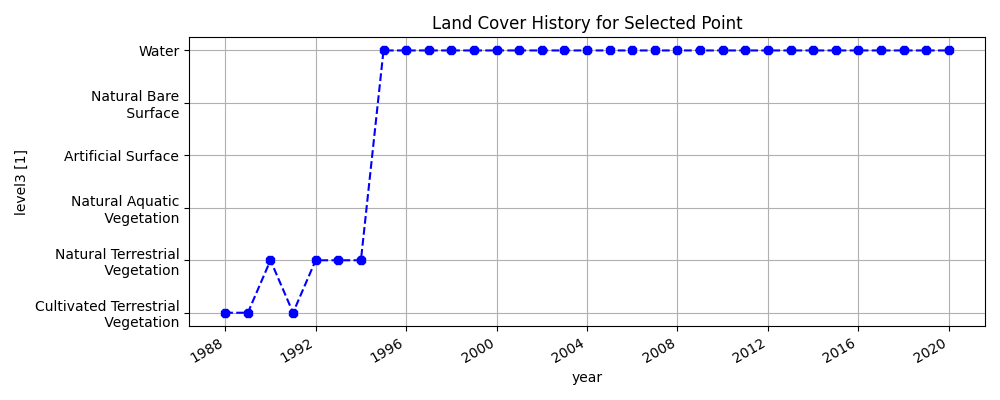

In [13]:
#define new figure and plot
fig, ax = plt.subplots(figsize=(10,4))
number_labels = (0, 1, 2, 3, 4, 5, 6)
label_classes = ('No Data', 'Cultivated Terrestrial\n Vegetation', 'Natural Terrestrial\n Vegetation', 
                 'Natural Aquatic\n Vegetation', 'Artificial Surface', 'Natural Bare\n Surface', 'Water')

plt.yticks(number_labels, label_classes)#make lables be class names
new_data.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.xlabel("year")
plt.title("Land Cover History for Selected Point")
plt.grid()
plt.tight_layout()
plt.show